In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('cpu')

In [3]:
y_mean = torch.mean(y_train)
y_sd = torch.std(y_train)

y_train = (y_train - y_mean) / y_sd

In [4]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [10, 10], learning_rate = 0.001, calibration_threshold = .03)

initial loss:  1.1303246021270752
final loss:  -3.4013798236846924


End2end test MAPE:  0.36777952
End2end test RMSE:  49.018024
End2end test NLLK:  7.6186905
End2end test CRPS:  tensor(19.2814)


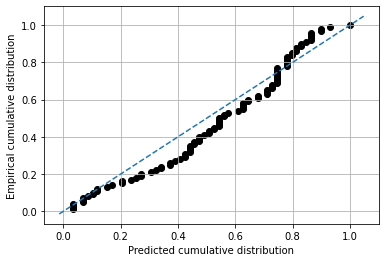

End2end test calibration error when step size is 0.001:  4.564714593507611
End2end test calibration error when step size is 0.01:  0.4643134156851478
End2end test calibration error when step size is 0.1:  0.037015225509910925


In [5]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.61it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.66it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           27.562
  RMSE          49.018
  MDAE          12.188
  MARPD         31.927
  R2            0.867
  Correlation   0.932
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.077
  Mean-absolute Calibration Error       0.066
  Miscalibration Area                   0.067
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.220
     Group Size: 0.56 -- Calibration Error: 0.134
     Group Size: 1.00 -- Calibration Error: 0.066
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.283
     Group Size: 0.56 -- Calibration Error: 0.132
     Group Size: 1.00 -- Calibration Error: 0.077
============

Lims is None. Setting lims now:
min_max_true: (7.0, 915.0)
min_max_pred: (12.524513, 732.3717)
lims: (7.0, 915.0)
lims_ext: (-83.80000000000001, 1005.8)


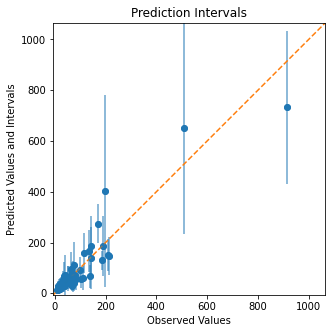

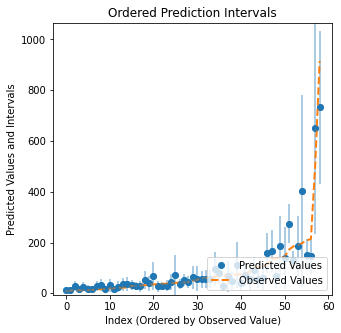

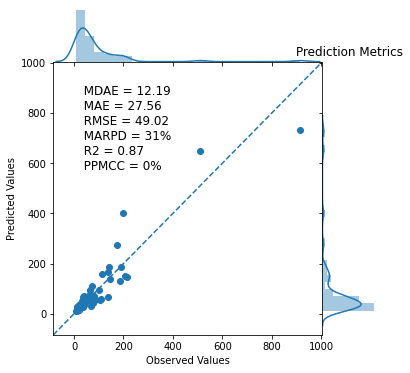

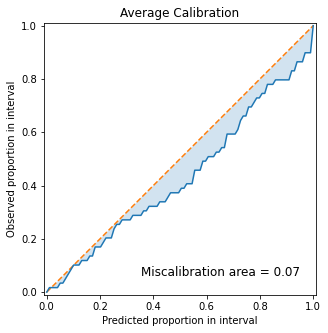

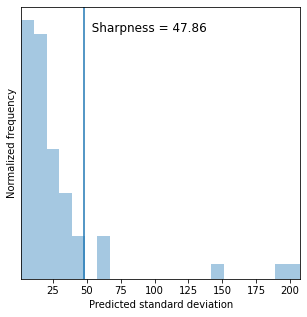

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [4]:
nllk_model = end2end_crps.train_model_nllk(x_train, y_train, n_epoch = 500, hidden_layers = [10, 10], learning_rate = 0.001, calibration_threshold = .03)

initial loss:  1.0968176126480103
final loss:  -3.3528077602386475


End2end test MAPE:  0.35022083
End2end test RMSE:  60.787167
End2end test NLLK:  7.850757
End2end test CRPS:  tensor(21.7911)


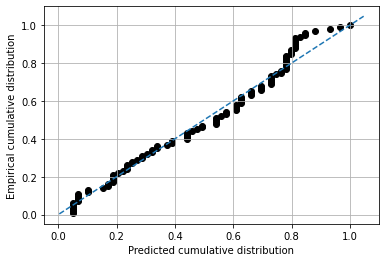

End2end test calibration error when step size is 0.001:  1.6901567078425734
End2end test calibration error when step size is 0.01:  0.17082303935650675
End2end test calibration error when step size is 0.1:  0.014263142775064625


In [5]:
mean_pred, var_pred = nllk_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.66it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 12.01it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.77it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           29.047
  RMSE          60.787
  MDAE          11.524
  MARPD         31.917
  R2            0.796
  Correlation   0.943
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.053
  Mean-absolute Calibration Error       0.042
  Miscalibration Area                   0.042
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.242
     Group Size: 0.56 -- Calibration Error: 0.084
     Group Size: 1.00 -- Calibration Error: 0.042
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.281
     Group Size: 0.56 -- Calibration Error: 0.106
     Group Size: 1.00 -- Calibration Error: 0.053
============

Lims is None. Setting lims now:
min_max_true: (7.0, 915.0)
min_max_pred: (11.949234, 1064.7864)
lims: (7.0, 1064.7864)
lims_ext: (-98.77863769531251, 1170.5650146484375)


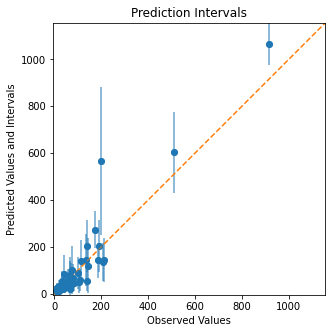

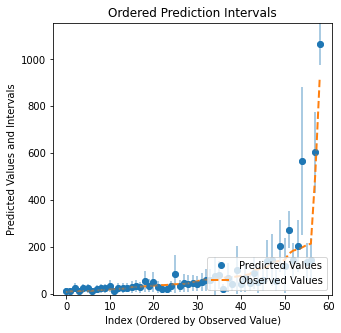

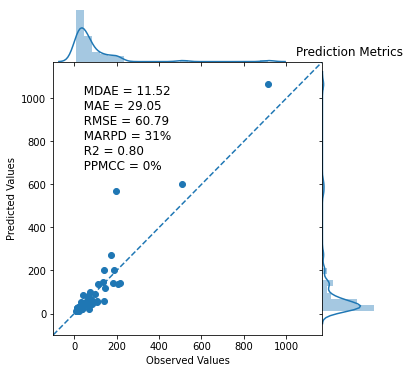

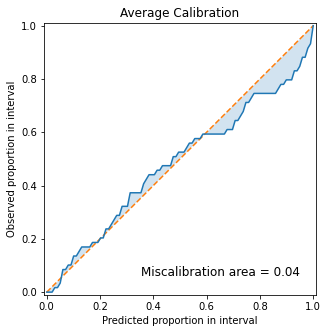

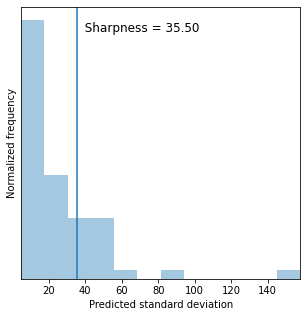

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [8]:
crps_model = end2end_crps.train_model_crps(x_train, y_train, n_epoch = 500, hidden_layers = [10, 10], learning_rate = 0.001, calibration_threshold = .03)

initial loss:  0.547964870929718
final loss:  0.06949342787265778


End2end test MAPE:  0.4086535
End2end test RMSE:  46.33689
End2end test NLLK:  18.592768
End2end test CRPS:  tensor(21.3352)


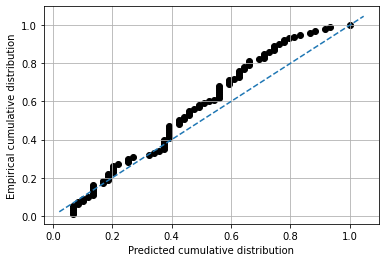

End2end test calibration error when step size is 0.001:  6.585144355070384
End2end test calibration error when step size is 0.01:  0.6548161447859814
End2end test calibration error when step size is 0.1:  0.06430623384085038


In [11]:
mean_pred, var_pred = crps_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [12]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.93it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.73it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           27.074
  RMSE          46.337
  MDAE          12.872
  MARPD         40.985
  R2            0.881
  Correlation   0.964
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.104
  Mean-absolute Calibration Error       0.093
  Miscalibration Area                   0.094
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.246
     Group Size: 0.56 -- Calibration Error: 0.152
     Group Size: 1.00 -- Calibration Error: 0.093
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.278
     Group Size: 0.56 -- Calibration Error: 0.151
     Group Size: 1.00 -- Calibration Error: 0.104
============

Lims is None. Setting lims now:
min_max_true: (7.0, 915.0)
min_max_pred: (-17.205627, 1106.5035)
lims: (-17.205627, 1106.5035)
lims_ext: (-129.57655029296876, 1218.874462890625)


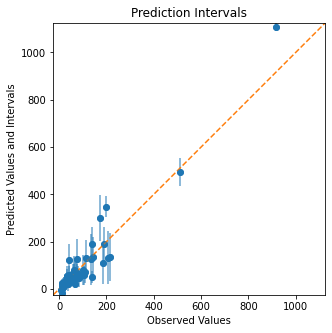

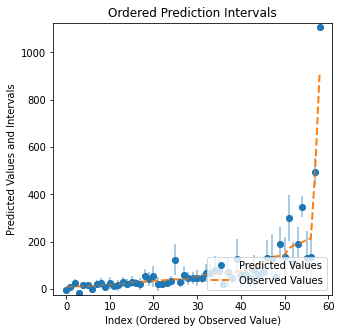

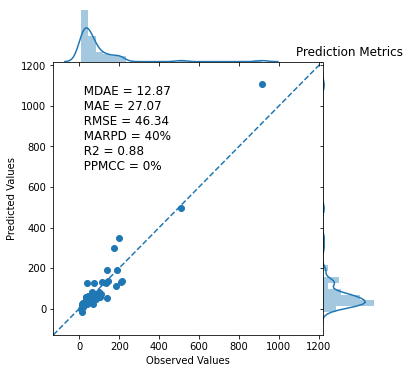

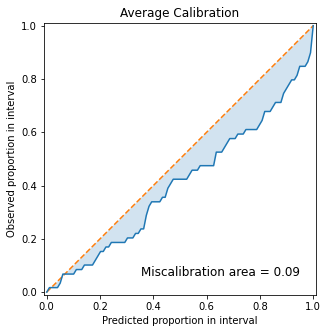

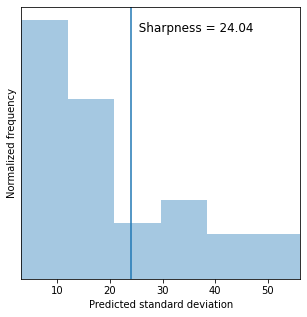

In [13]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))